## Forward modelling of the radial velcoity (RV) process

Using the HD164922 dataset

In [5]:
import os
import emcee
import corner
import radvel
import numpy as np
import pandas as pd

from tqdm import tqdm
import scipy.stats as stats
from matplotlib import pyplot as plt
from scipy.optimize import newton, minimize

### 1. Import and process data

Function to condense observations into a single RV value per night

In [6]:
# import data
path = os.path.join(radvel.DATADIR,'164922_fixed.txt')
data = pd.read_csv(path, usecols=(0,1,2,3), delim_whitespace=True)

# time base
time_base = 2456778

# process data - condense to one observation per night
def process_data_same_night(rv_data):

    # Normalise the time data
    rv_data['time'] = rv_data['time'] - time_base

    # Convert time to Julian Date (JD) - round data to int
    rv_data['julian_date'] = rv_data['time'].apply(lambda x: int(np.floor(x)))

    # Group by JD and calculate mean values for each group
    rv_mean = rv_data.groupby('julian_date').agg({'mnvel': 'mean', 'errvel': 'mean'})

    # Get the number of observations per JD
    rv_size = rv_data.groupby('julian_date').size()

    # Calculate the adjusted error for velocity
    rv_mean['errvel'] = rv_mean['errvel'] / np.sqrt(rv_size)

    # Reset the index to make julian_date a column
    rv_mean.reset_index(inplace=True)

    return rv_mean

Applying the bin same night to data from each telescope: k, j, a

In [152]:
# Separate data by telescope
rv_hires_rk = data.query("tel == 'k'")
rv_hires_rj = data.query("tel == 'j'")
rv_apf = data.query("tel == 'a'")

# Process data
rv_hires_rj = process_data_same_night(rv_hires_rj)
rv_hires_rk = process_data_same_night(rv_hires_rk)
rv_apf = process_data_same_night(rv_apf)

# Get the time span of the data
t_start = min(data['time'].values) - time_base
t_stop = max(data['time'].values) - time_base
ti = np.linspace(t_start, t_stop, 240)

dataset = rv_hires_rj, rv_hires_rk, rv_apf

combined_data = pd.concat(dataset, ignore_index=True)

### Initialise model and instrument parameters

Radial Velcoity equation:
$$RV(t) = K \left[ \cos(v(t) + \omega) + e \cos(\omega) \right] + \gamma$$

Model parameters:
- $K$ - semi-amplitude of the RV curve (logk)
- $v(t)$ - true anomaly
- $\omega$ - argument of periastron (secosw, sesinw)
- $e$ - eccentricity (secosw, sesinw)

where secosw = $\sqrt{e} \cos(\omega)$ and sesinw = $\sqrt{e} \sin(\omega)$.

Intrument parameters:
- $\gamma$ - systemic velocity

In [153]:
# time base
time_base = 2456778

# RV parameters planet b
per1 = 1201.1 + 0.4 # period in days
tc1 = 2456778 + 1 - time_base # time of inferior conjunction in JD
secosw1 = 0.01 # eccentricity times cosine of argument of periastron
sesinw1 = 0.01 # eccentricity times sine of argument of periastron
logk1 = 1 # log amplitude of RV signal

# RV parameters planet c
per2 = 75.765 + 0.1
tc2 = 2456277.6 - time_base
secosw2 = 0.01
sesinw2 = 0.01
logk2 = 1

# Instrumental and Observational Parameters
dvdt = 0 # m/s/day
curv = 0 # m/s/day^2

# jitter
jitter = np.log(2.6)

params = [per1, tc1, secosw1, sesinw1, logk1, per2, tc2, secosw2, sesinw2, logk2, dvdt, curv, jitter]

bounds = [(None, None), (None, None), (-1, 1), (-1, 1), (None, None), (None, None), (None, None), (-1, 1), (-1, 1), (None, None), (dvdt, dvdt), (curv, curv), (jitter, jitter)] 

### Define kepler orbit equations

#### True Anomaly

Mean anomaly:
$$M(t) = \frac{2\pi}{P} (t - T_c)$$

True anomaly:
$$v(t) = 2 \arctan \left( \sqrt{\frac{1+e}{1-e}} \tan \left( \frac{E}{2} \right) \right)$$

where $E$ is the eccentric anomaly solved from Kepler's equation:
$$E - e \sin(E) = M$$

In [154]:
# Solve Kepler's equation
def solve_kepler(e, M):
    E = newton(lambda E: E - e * np.sin(E) - M, M)
    return E

# Calculate the RV signal
def keplerian_signal(t, tc, per, K, secosw, sesinw):

    # Eccentricity and omega
    e = np.sqrt(secosw**2 + sesinw**2)
    omega = np.arctan2(sesinw, secosw)

    # Mean anomaly
    M = 2 * np.pi * (t - tc) / per

    # Eccentricity
    E = solve_kepler(e, M)

    # True anomaly
    nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), np.sqrt(1 - e) * np.cos(E / 2))

    return K * (np.cos(nu + omega) + e * np.cos(omega))

# Model RV for system with two planets
def model_rv(t, params):

    per1, tc1, secosw1, sesinw1, logk1, per2, tc2, secosw2, sesinw2, logk2, dvdt, curv, jitter = params

    # Calculate RV signals
    K1 = 10**logk1
    K2 = 10**logk2
    rv1 = keplerian_signal(t, tc1, per1, K1, secosw1, sesinw1)
    rv2 = keplerian_signal(t, tc2, per2, K2, secosw2, sesinw2)

    # Linear and quadratic trend
    linear = dvdt * (t - time_base)
    quad = curv * (t - time_base)**2

    return rv1 + rv2 + linear + quad

### Define log-likelihood function

$$\mathcal{L}(\theta | \text{data}) \propto \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp\left(-\frac{(v_{\text{obs},i} - v_{\text{model},i}(\theta))^2}{2\sigma_i^2}\right)
$$


In [155]:
def log_likelihood(params, t, rv, rv_err):

    # add jitter term
    jitter = np.exp(params[-1])

    # model prediction
    rv_model = model_rv(t, params)

    # rediduals
    resdiduals = rv - rv_model

    # total error
    total_err = np.sqrt(rv_err**2 + jitter**2)

    # log likelihood
    logL = -0.5 * np.sum((resdiduals / total_err)**2 + np.log(2 * np.pi * total_err**2))  

    return logL

### Define prior distributions
Beta distribution for $e$ bound between 0 and 1

In [156]:
# Define beta prior for eccentricity
def log_prior_ecc(e, alpha=0.867, beta=3.03):
    if 0 <= e < 1:
        return np.log(stats.beta.pdf(e, alpha, beta))
    else:
        return -np.inf

### Construct composite likelihood
The likelihoods need to be combined as observations are from different telescopes

In [157]:
def composite_log_likelihood(params):

    # initialise total log likelihood
    total_logL = 0

    # likelihood rj
    like_rj = log_likelihood(params, rv_hires_rj['julian_date'], rv_hires_rj['mnvel'], rv_hires_rj['errvel'])

    # likelihood rk
    like_rk = log_likelihood(params, rv_hires_rk['julian_date'], rv_hires_rk['mnvel'], rv_hires_rk['errvel'])
    
    # likelihood apf
    like_apf = log_likelihood(params, rv_apf['julian_date'], rv_apf['mnvel'], rv_apf['errvel'])

    # composite likelihoods
    total_logL = like_rk + like_rj + like_apf

    return total_logL

### Define posterior distribution

In [13]:
def log_posterior(params):

    # unpack parameters
    per1, tc1, secosw1, sesinw1, logk1, per2, tc2, secosw2, sesinw2, logk2, dvdt, curv, jitter = params

    # eccentricitys
    e1 = np.sqrt(secosw1**2 + sesinw1**2)
    e2 = np.sqrt(secosw2**2 + sesinw2**2)

    # Calculate log prior
    logP = 0
    logP += log_prior_ecc(e1)
    logP += log_prior_ecc(e2)

    # Calculate log likelihood
    logL = composite_log_likelihood(params)

    return logL + logP

### Construct log-posterior

In [14]:
log_post = log_posterior(params)

### Maximum Log-Likelihood Estimation

In [15]:
# optimize
result = minimize(lambda params: -log_post, params, bounds=bounds, method='Powell')

In [190]:
result

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1607.804165254343
       x: [ 1.204e+03  3.588e+00 ...  0.000e+00  9.555e-01]
     nit: 1
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 158

In [16]:
# Define your parameter names
param_names = ['per1', 'tc1', 'secosw1', 'sesinw1', 'logk1', 
               'per2', 'tc2', 'secosw2', 'sesinw2', 'logk2', 
               'dvdt', 'curv']

# Assuming 'result.x' contains the optimized parameter values
param_values = result.x

# Create a dictionary from names and values
param_dict = dict(zip(param_names, param_values))

print("Prior posterior: ", log_post)
print(param_dict)

Prior posterior:  -1607.804165254343
{'per1': 1204.087928961546, 'tc1': 3.587928961545842, 'secosw1': 0.9999516353181774, 'sesinw1': 0.9999516353181774, 'logk1': 3.587928961545842, 'per2': 78.45292896154584, 'tc2': -497.812071038361, 'secosw2': 0.9999516353181774, 'sesinw2': 0.9999516353181774, 'logk2': 3.587928961545842, 'dvdt': 0.0, 'curv': 0.0}


#### MCMC Posterior Exploration

In [31]:
# Define the number of walkers, dimensions, and steps
nwalkers, ndim, nsteps = 28, len(params), 5000

# Initialize the walkers in a small Gaussian ball around the initial values
starting_guesses = params + 1e-4 * np.random.randn(nwalkers, ndim)

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

# Run the MCMC
sampler.run_mcmc(starting_guesses, nsteps, progress=True)

100%|██████████| 5000/5000 [07:59<00:00, 10.43it/s]


In [34]:
# Discard burn-in and thin
samples = sampler.get_chain(discard=3000, thin=15, flat=True)

### Trace plot of MCMC chains

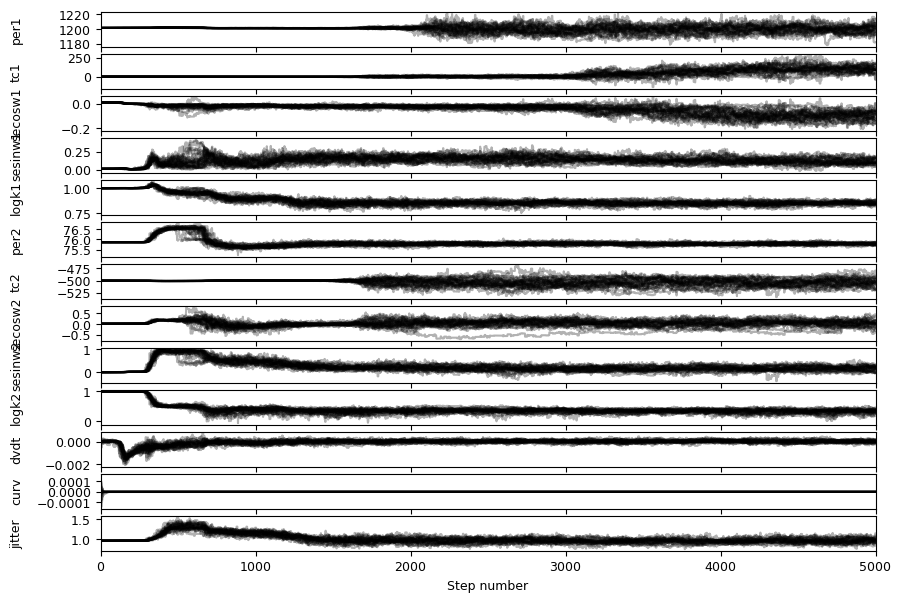

In [188]:
def plot_trace(sampler, params):
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = params  # Ensure this list matches the order of parameters used in the sampler
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("Step number")
    plt.show()

plot_trace(sampler, ['per1', 'tc1', 'secosw1', 'sesinw1', 'logk1', 'per2', 'tc2', 'secosw2', 'sesinw2', 'logk2', 'dvdt', 'curv', 'jitter'])


### Post MCMC processing

In [47]:
e1_samples = np.sqrt(samples[:, 2]**2 + samples[:, 3]**2)  # sqrt(secosw1^2 + sesinw1^2)
e2_samples = np.sqrt(samples[:, 7]**2 + samples[:, 8]**2)

# Create a DataFrame for corner plot
df_corner = pd.DataFrame({
    'per1': samples[:, 0],
    'tc1': samples[:, 1],
    'e1': e1_samples,
    'k1': 10**samples[:, 4],
    'per2': samples[:, 5],
    'tc2': samples[:, 6],
    'e2': e2_samples,
    'k2': 10**samples[:, 9]
})

# Create a Dataframe for RV plot
df_synth = pd.DataFrame({
    'per1': samples[:, 0],
    'tc1': samples[:, 1],
    'secosw1': samples[:, 2],
    'sesinw1': samples[:, 3],
    'logk1': samples[:, 4],
    'per2': samples[:, 5],
    'tc2': samples[:, 6],
    'secosw2': samples[:, 7],
    'sesinw2': samples[:, 8],
    'logk2': samples[:, 9],
    'dvdt': samples[:, 10],
    'curv': samples[:, 11],
    'jitter': samples[:, 12]
})

# Calculate quantiles
quantiles = df_corner.quantile([0.16, 0.5, 0.84]).T
quantiles.columns = ['16%', '50%', '84%']
print(quantiles)

              16%          50%          84%
per1  1194.143801  1199.933215  1204.945818
tc1     14.587069    68.336262   123.002214
e1       0.110503     0.152482     0.191851
k1       6.782766     7.065590     7.369328
per2    75.726727    75.782418    75.836715
tc2   -512.459856  -503.742735  -495.082074
e2       0.118336     0.212429     0.326125
k2       1.868732     2.182338     2.484227


In [189]:
df_corner

,per1,tc1,e1,k1,per2,tc2,e2,k2
0,1200.349965,21.983904,0.142939,7.159035,75.780082,-507.865186,0.228786,2.087576
1,1202.325761,6.054878,0.202114,7.296590,75.823305,-509.537156,0.314822,2.453887
2,1185.586611,-9.415690,0.202643,7.427616,75.760748,-488.125751,0.112068,1.676647
3,1198.522078,17.263179,0.175262,7.994416,75.769569,-520.300565,0.320944,1.728097
4,1202.340601,-1.458091,0.135478,6.779217,75.940267,-498.789069,0.076533,1.941226
...,...,...,...,...,...,...,...,...
3719,1209.600271,96.470330,0.110692,7.008185,75.688121,-504.315370,0.227857,2.298011
3720,1207.987960,183.798855,0.185440,6.875660,75.764273,-509.907984,0.449968,2.711216
3721,1200.611068,85.583398,0.136403,7.140986,75.732444,-501.084071,0.263576,2.142995
3722,1196.642894,93.167981,0.105062,7.009233,75.831801,-490.225928,0.347952,2.029437


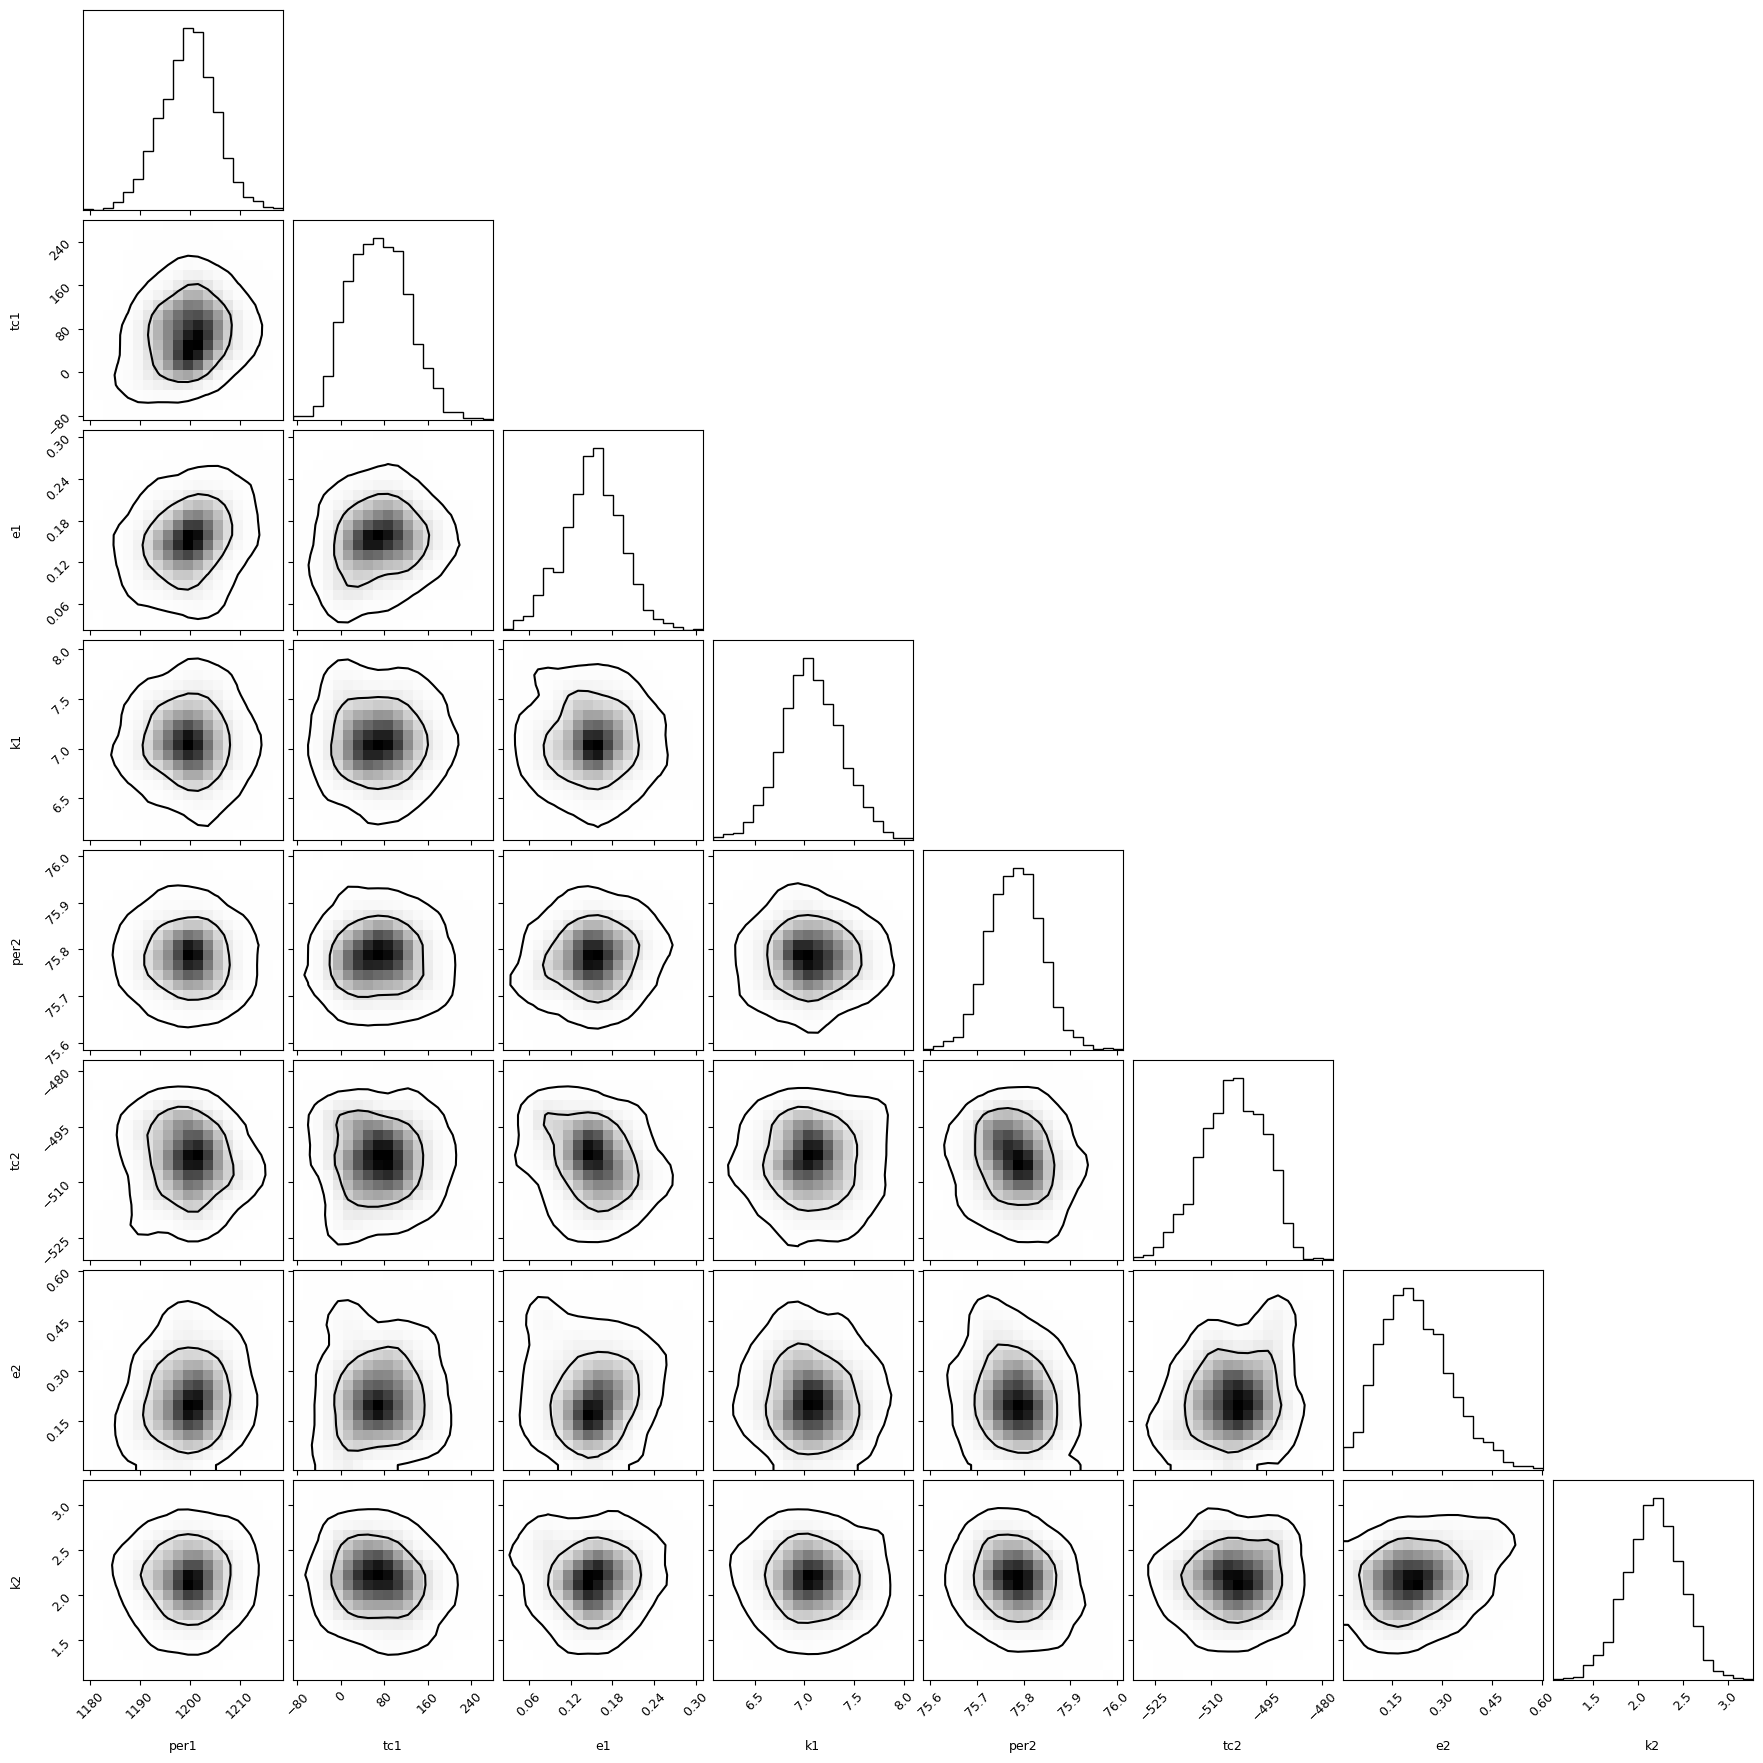

In [48]:
# Selecting labels for the parameters to include in the corner plot
labels = ['per1', 'tc1', 'e1', 'k1', 'per2', 'tc2', 'e2', 'k2']

fig = corner.corner(
    df_corner[labels],  # DataFrame with the parameters
    labels=labels,
    levels=[0.68, 0.95],  
    plot_datapoints=False, 
    smooth=True)
plt.show()  # Show the plot

### Radial Velocity curve time series

In [158]:
# Calculate the median values from posterior samples
median_params = df_synth.median()
t_model = ti 
t_obs = combined_data['julian_date']
rv_obs = combined_data['mnvel']
rv_err = combined_data['errvel']

# RV predictions
rv_predictions = model_rv(t_model, median_params)
residuals = rv_obs - rv_predictions

### Plot Radial Velocity curve

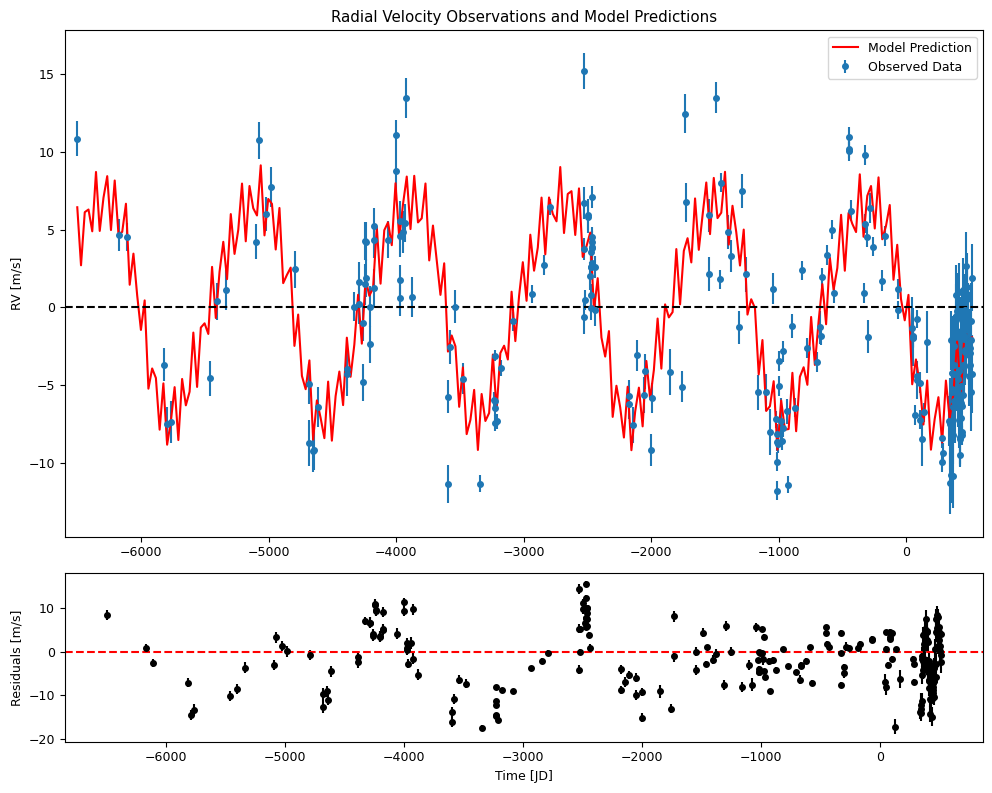

In [159]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10, 8))

# Top panel: Observations and Model
ax1.errorbar(t_obs, rv_obs, yerr=rv_err, fmt='o', label='Observed Data', markersize=4)
ax1.plot(t_model, rv_predictions, label='Model Prediction', color='r')
ax1.hlines(0, -6600, 600, color='k', linestyle='--')
ax1.set_xlim(-6600, 600)
ax1.set_ylabel('RV [m/s]')
ax1.legend()
ax1.set_title('Radial Velocity Observations and Model Predictions')

# Bottom panel: Residuals
ax2.errorbar(t_obs, residuals, yerr=rv_err, fmt='o', color='k', markersize=4)
ax2.axhline(0, color='red', linestyle='--')
ax2.set_xlabel('Time [JD]')
ax2.set_ylabel('Residuals [m/s]')

# Improve layout
plt.tight_layout()
plt.show()

### Plot planet RV curves

In [168]:
# Calculate the median parameters for planet b and planet c
params_b = df_synth[['per1', 'tc1', 'secosw1', 'sesinw1', 'logk1']].median()
params_c = df_synth[['per2', 'tc2', 'secosw2', 'sesinw2', 'logk2']].median()

# Function to calculate orbital phase
def phase_fold(t, P, T0):
    return ((t - T0 + 0.5 * P) % P) - 0.5 * P

# Phase folding the times for both planets
phase_b = phase_fold(t_obs, params_b['per1'], params_b['tc1'])
phase_c = phase_fold(t_obs, params_c['per2'], params_c['tc2'])

# Calculate model predictions for both datasets
rv_model_b = keplerian_signal(t_obs, params_b['tc1'], params_b['per1'], 10**params_b['logk1'], params_b['secosw1'], params_b['sesinw1'])
rv_model_c = keplerian_signal(t_obs, params_c['tc2'], params_c['per2'], 10**params_c['logk2'], params_c['secosw2'], params_c['sesinw2'])

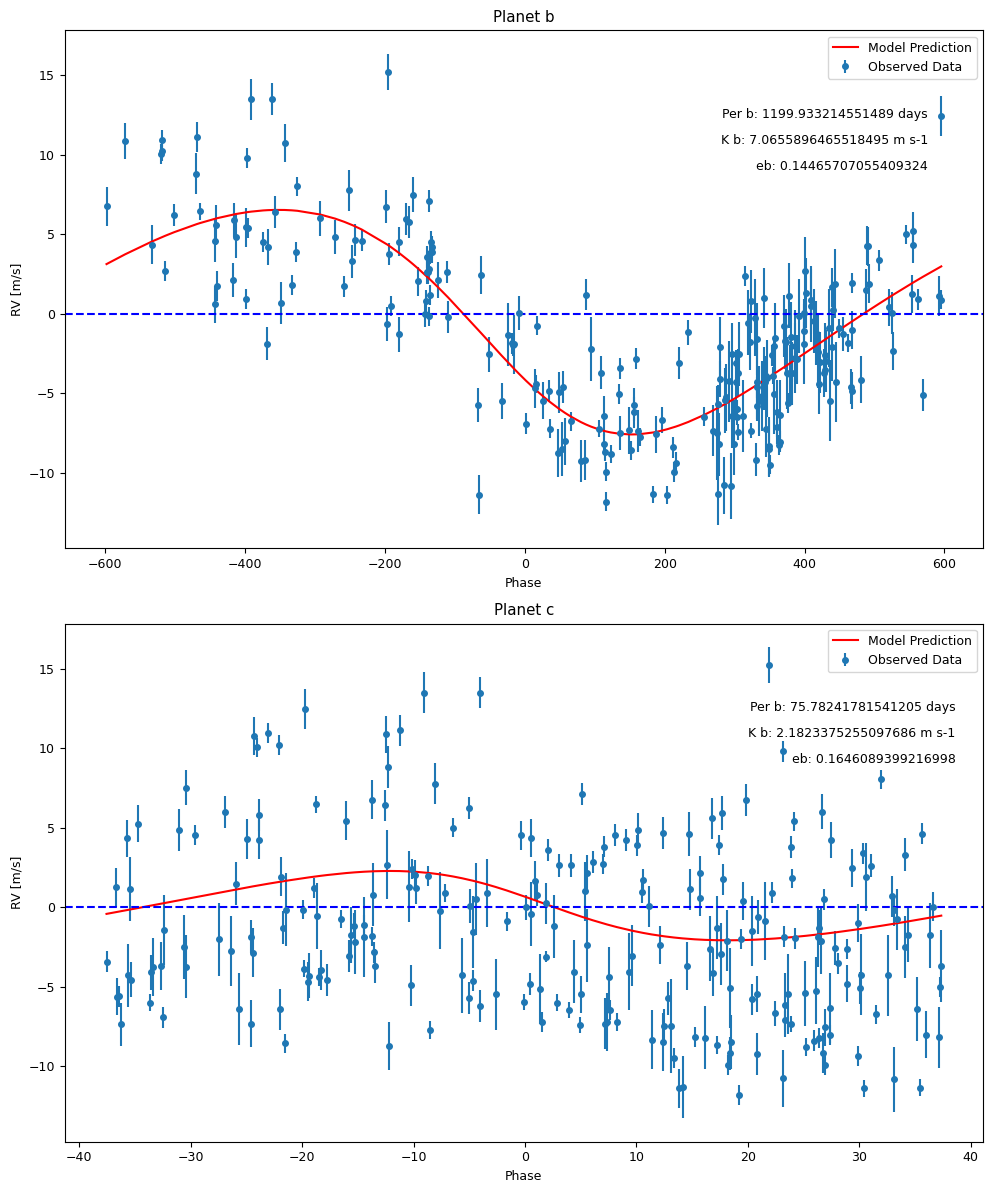

Planet b:
Per b:  1199.933214551489
K b:  7.0655896465518495
e b:  0.14465707055409324
Planet c:
Per c:  75.78241781541205
K c:  2.1823375255097686
e c:  0.1646089399216998


In [186]:
# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot for planet b
ax1.errorbar(phase_b, rv_obs, yerr=rv_err, fmt='o', label='Observed Data', markersize=4)
ax1.plot(np.sort(phase_b), rv_model_b[np.argsort(phase_b)], label='Model Prediction', color='red')
ax1.axhline(0, color='blue', linestyle='--')
ax1.set_title('Planet b')
ax1.set_xlabel('Phase')
ax1.set_ylabel('RV [m/s]')
ax1.legend()

# Plot for planet c
ax2.errorbar(phase_c, rv_obs, yerr=rv_err, fmt='o', label='Observed Data', markersize=4)
ax2.plot(np.sort(phase_c), rv_model_c[np.argsort(phase_c)], label='Model Prediction', color='red')
ax2.axhline(0, color='blue', linestyle='--')
ax2.set_title('Planet c')
ax2.set_xlabel('Phase')
ax2.set_ylabel('RV [m/s]')
ax2.legend()

# Adding text annotations for planet b
ax1.text(0.94, 0.85, "Per b: {} days".format(params_b['per1']), verticalalignment='top', horizontalalignment='right', transform=ax1.transAxes, color='black')
ax1.text(0.94, 0.8, "K b: {} m s-1".format(10**params_b['logk1']), verticalalignment='top', horizontalalignment='right', transform=ax1.transAxes, color='black')
ax1.text(0.94, 0.75, 'eb: {}'.format(np.sqrt(params_b['secosw1']**2 + params_b['sesinw1']**2)), verticalalignment='top', horizontalalignment='right', transform=ax1.transAxes, color='black')

# Adding text annotations for planet c
ax2.text(0.97, 0.85, "Per b: {} days".format(params_c['per2']), verticalalignment='top', horizontalalignment='right', transform=ax2.transAxes, color='black')
ax2.text(0.97, 0.8, "K b: {} m s-1".format(10**params_c['logk2']), verticalalignment='top', horizontalalignment='right', transform=ax2.transAxes, color='black')
ax2.text(0.97, 0.75, 'eb: {}'.format(np.sqrt(params_c['secosw2']**2 + params_c['sesinw2']**2)), verticalalignment='top', horizontalalignment='right', transform=ax2.transAxes, color='black')


plt.tight_layout()
plt.show()

# print
print("Planet b:")
print("Per b: ", params_b['per1'])
print("K b: ", 10**params_b['logk1'])
print("e b: ", np.sqrt(params_b['secosw1']**2 + params_b['sesinw1']**2))

print("Planet c:")
print("Per c: ", params_c['per2'])
print("K c: ", 10**params_c['logk2'])
print("e c: ", np.sqrt(params_c['secosw2']**2 + params_c['sesinw2']**2))